# Deep Learning Applications: Laboratory #1
In this laboratory I will define a framework which follows the [Open/Closed Principle](https://en.wikipedia.org/wiki/Open%E2%80%93closed_principle) which allows with very simple code to successfully run the following tasks:

1.   Train a simple **MLP** to classify the 10 digits of MNIST;
2.   Train a simple **CNN** to classify the 10 classes of CIFAR10;
3.   Train a **Res-Net** to classify the 10 classes of CIFAR10. Show the differences of the **Res-Net** with and without the skip connections (a normal CNN).
4.   Take one of the trained classifiers, **fully-convolutionalize** it and test the fully-convolutionalized networks on a modified mnist dataset which embeds 4 digits in the same image.





#### Google colab setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)



In [ ]:
!pip install wandb
!pip install torchmetrics

#### Basic Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb
import torchmetrics

#### Let's define all the models we need and understand if their output is correct

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i != len(layer_sizes) - 2: #the last layer doesn't have relu
                layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return self.mlp(x)

x = torch.rand(1, 30, 20)
model = MLP([(600),100,10])
out = model(x)
print(out)

class CNN(nn.Module):
    def __init__(self, layer_channels, layers_before_max_pool=2, output_dim=10):
        super(CNN, self).__init__()
        layers = []

        for i in range(len(layer_channels) - 1):
            layers.append(nn.Conv2d(layer_channels[i], layer_channels[i + 1], kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(layer_channels[i + 1]))
            layers.append(nn.LeakyReLU())
            if (i + 1) % layers_before_max_pool == 0:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv = nn.Sequential(*layers)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.mlp = nn.Sequential(
            nn.Linear(layer_channels[-1], 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.conv(x)

        x = self.pool(x).view(x.size(0), -1)

        return self.mlp(x)

layer_channels = [3, 16, 32, 64, 128, 256]
model = CNN(layer_channels=layer_channels, output_dim=10)

x = torch.rand(1, 3, 28, 28) #(batch_size, channels, height, width)
out = model(x)
print(out)

class ConvBlock(nn.Module):
    def __init__(self, num, input_channels, output_channels, kernel_size=3, res_connection=False):
        super(ConvBlock, self).__init__()
        self.res_connection = res_connection

        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=(kernel_size // 2))
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=(kernel_size // 2))
        self.bn2 = nn.BatchNorm2d(input_channels)

        self.final_conv = nn.Conv2d(input_channels, output_channels, 1)
        self.final_bn = nn.BatchNorm2d(output_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.res_connection:
            out += identity

        out = self.final_bn(self.final_conv(out))

        return out


class ResCNN(nn.Module):
    def __init__(self, layer_channels, num_repeats, output_dim=10, res_connection=False):
        super(ResCNN, self).__init__()
        self.res_connection = res_connection

        blocks = []

        blocks.append(nn.Conv2d(layer_channels[0], layer_channels[1], kernel_size=3, padding=1))

        for i in range(1, len(layer_channels) - 1):
            in_channels = layer_channels[i]
            out_channels = layer_channels[i + 1]
            block = ConvBlock(num_repeats, in_channels, out_channels, res_connection=self.res_connection)
            blocks.append(block)

        self.blocks = nn.ModuleList(blocks)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(layer_channels[-1], 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.head(x)
        return x


layer_channels = [3, 16, 32, 64, 128, 256]
model = ResCNN(layer_channels=layer_channels, num_repeats=2, output_dim=10, res_connection=True)

x = torch.rand(1, 3, 28, 28)
out = model(x)
print(out)

class FullyConvCNN(nn.Module):
    def __init__(self, layer_channels, num_repeats, output_dim=10, res_connection=False, checkpoint=None):
        super(FullyConvCNN, self).__init__()
        self.backbone = ResCNN(layer_channels, num_repeats, output_dim, res_connection)
        if checkpoint != None:
            self.backbone.load_state_dict(torch.load(checkpoint))
        self.backbone.head = nn.Identity()


        self.classification_head = nn.Sequential(
          nn.MaxPool2d(kernel_size=4, stride=4),
          nn.ConvTranspose2d(layer_channels[-1], layer_channels[-1]//2, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
          nn.BatchNorm2d(layer_channels[-1]//2),
          nn.ConvTranspose2d(layer_channels[-1]//2, layer_channels[-1]//4, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
          nn.BatchNorm2d(layer_channels[-1]//4),
          nn.Conv2d(layer_channels[-1]//4, output_dim+1, kernel_size=1),
        )

    def forward(self, x):
        return self.classification_head(self.backbone(x))


layer_channels = [3, 64, 128, 256, 256, 256]
model = FullyConvCNN(layer_channels=layer_channels, num_repeats=2, output_dim=10, res_connection=True)
x = torch.rand(1, 3, 28, 28)
out = model(x)
print(out.shape)

#### Let's define the Trainer class which will be based on a configuration dictionary which define all the aspects of the experiment to run

In [7]:
class Trainer:
    def __init__(self, config):


        self.config = config
        if config["use_wandb"] == True:
          self.use_wandb = True
          wandb.init(project="LAB1", config=config)

        else:
          self.use_wandb = False

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epochs = config["num_epochs"]

        match config["loss"]:

          case "cross_entropy":
            self.loss = nn.CrossEntropyLoss()
            if config["dataset"] == "fully_cnn_mnist":
              num_classes = 11
              major_class_weight = 0.02
              minor_class_weight = (1 - major_class_weight) / (num_classes - 1)

              # Creating a tensor for class weights
              class_weights = torch.tensor([minor_class_weight] * (num_classes - 1) + [major_class_weight])
              class_weights = class_weights.to(self.device)
              print("To solve class unbalance these are the weights given to the loss:")
              print(class_weights)
              # Define the criterion with the class weights
              self.loss = nn.CrossEntropyLoss(weight=class_weights)

          case _:
            raise ValueError(f'Loss not found. Received {config["loss"]}.')


        match config["dataset"]:

          case "mnist":
            dataset = MNIST
            self.input_size = 28*28
            self.output_size = 10
            self.input_channels = 1
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
            test_dataset = dataset(root='./data', train=False, download=True, transform=transform)
            train_dataset, validation_dataset = split_validation_train(train_dataset=train_dataset, val_size=0.2)

            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

          case "cifar10":
            dataset = CIFAR10
            self.input_size = 32*32*3
            self.output_size = 10
            self.input_channels = 3
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
            test_dataset = dataset(root='data', train=False, transform=transform, download=True)
            train_dataset, validation_dataset = split_validation_train(train_dataset=train_dataset, val_size=0.2)

            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

          case "fully_cnn_mnist":
            dataset = MNIST
            self.input_size = 28*28
            self.output_size = 10
            self.input_channels = 1
            transform_train = transforms.Compose([
                transforms.ToPILImage(),
                #transforms.RandomAffine(0, translate=(0.4, 0.4)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            transform_test = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            train_dataset = FullyTrainMNIST4(root='data', train=True, transform=transform_train, download=True)
            test_dataset = FullyTestMNIST4(root='data', train=False, transform=transform_test, download=True)
            train_dataset, validation_dataset = split_validation_train(train_dataset=train_dataset, val_size=0.2)

            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

          case _:
            raise ValueError(f'Dataset not found. Received {config["dataset"]}.')





        self.metrics = []
        output_size = self.output_size
        if config["model"] == "fully_conv_cnn": # it has the background also
          output_size += 1

        for metric in config["metrics"]:

            match metric:

                case "accuracy":
                    self.metrics.append(torchmetrics.Accuracy(task="multiclass", num_classes=output_size).to(self.device))

                case "precision":
                    self.metrics.append(torchmetrics.Precision(task="multiclass", average='macro', num_classes=output_size).to(self.device))

                case "recall":
                    self.metrics.append(torchmetrics.Recall(task="multiclass", average='macro', num_classes=output_size).to(self.device))

                case _:
                    raise ValueError(f'Metric not found. Received {metric}.')


        match config["model"]:

            case "mlp":
                layer_sizes = [self.input_size] + config["hidden_layer_sizes"] + [self.output_size]
                self.model = MLP(layer_sizes)

            case "cnn":
                layer_channels = [self.input_channels] + config["layer_channels"]
                self.model = CNN(layer_channels=layer_channels, output_dim=self.output_size)

            case "res_cnn":
                layer_channels = [self.input_channels] + config["layer_channels"]
                self.model = ResCNN(layer_channels=layer_channels, num_repeats=config["block_layers"], output_dim=self.output_size, res_connection=config["res"])

            case "fully_conv_cnn":
                layer_channels = [self.input_channels] + config["layer_channels"]
                self.model = FullyConvCNN(layer_channels=layer_channels, num_repeats=config["block_layers"], output_dim=self.output_size, res_connection=config["res"], checkpoint=config["checkpoint"])

            case _:
                raise ValueError(f'Model not found. Received {config["model"]}.')

        self.model.to(self.device)

        self.finetune = config.get("finetune", False)
        print("Finetune:")
        print(self.finetune)
        if self.finetune and config["model"] == "fully_conv_cnn":
            backbone_params = list(self.model.backbone.parameters())
            head_params = list(self.model.classification_head.parameters())
            lrs = [
                  {'params': backbone_params, 'lr': config["lr"]/1e2},
                  {'params': head_params, 'lr': config["lr"]}
            ]
        else:
            lrs = [
                  {'params': self.model.parameters(), 'lr': config["lr"]}
            ]

        match config["optimizer"]:

            case "adam":
                self.optimizer = optim.Adam(lrs)

            case "sgd":
                self.optimizer = optim.SGD(lrs)

            case "adamw":
                self.optimizer = optim.AdamW(lrs)

            case _:
                raise ValueError(f'Optimizer not found. Received {config["optimizer"]}.')



    def train_one_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0

        for inputs, labels in self.train_loader:
            self.optimizer.zero_grad()
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs).to(self.device)
            loss = self.loss(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Update metrics
            for metric in self.metrics:
                metric.update(outputs, labels)

        epoch_loss = running_loss / len(self.train_loader.dataset)

        # Log training loss and metrics to wandb
        metrics_log = {f"train_{metric.__class__.__name__}": metric.compute().item() for metric in self.metrics}
        if self.use_wandb:
          wandb.log({"train_loss": epoch_loss, **metrics_log})

        print(f'Epoch {epoch+1}/{self.num_epochs}, Loss: {epoch_loss:.4f}, ' +
              ", ".join([f"{k}: {v:.4f}" for k, v in metrics_log.items()]))

        # Reset metrics
        for metric in self.metrics:
            metric.reset()

    def validate(self, epoch):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Update metrics
                for metric in self.metrics:
                    metric.update(outputs, labels)

        epoch_val_loss = val_loss / len(self.val_loader.dataset)
        metrics_log = {f"val_{metric.__class__.__name__}": metric.compute().item() for metric in self.metrics}
        if self.use_wandb:
          wandb.log({"val_loss": epoch_val_loss, **metrics_log})

        print(f'Validation Loss: {epoch_val_loss:.4f}, ' +
              ", ".join([f"{k}: {v:.4f}" for k, v in metrics_log.items()]))

        # Reset metrics
        for metric in self.metrics:
            metric.reset()

    def test(self):
          self.model.eval()
          test_loss = 0.0
          with torch.no_grad():
              for inputs, labels in self.test_loader:
                  inputs, labels = inputs.to(self.device), labels.to(self.device)
                  outputs = self.model(inputs)
                  loss = F.cross_entropy(outputs, labels)
                  test_loss += loss.item() * inputs.size(0)

                  # Update metrics
                  for metric in self.metrics:
                      metric.update(outputs, labels)

          test_loss /= len(self.test_loader.dataset)
          metrics_log = {f"test_{metric.__class__.__name__}": metric.compute().item() for metric in self.metrics}
          if self.use_wandb:
            wandb.log({"test_loss": test_loss, **metrics_log})

          print(f'Test Loss: {test_loss:.4f}, ' +
                ", ".join([f"{k}: {v:.4f}" for k, v in metrics_log.items()]))

          # Reset metrics
          for metric in self.metrics:
              metric.reset()

          if self.config["dataset"] == "fully_cnn_mnist":
              self.show_image_with_gt(1)

    def run(self):
        print(self.model)
        for epoch in range(self.num_epochs):
            self.train_one_epoch(epoch)
            self.validate(epoch)

        if self.test_loader is not None:
            self.test()
        if self.use_wandb:
          wandb.finish()

    def show_image_with_gt(self, index):        # Retrieve the image and ground truth from the dataset
        i = 0
        for img, _ in self.test_loader:
          img = img.to(self.device)
          output = self.model(img)
          img = img.cpu()
          output = output.cpu()
          img_np = img.squeeze().numpy()
          output = output.detach().numpy()

          for i in range(10):#img_np.shape[0]
            # Convert the image tensor to a numpy array
            img = img_np[i]
            gt_img_np = output[i]

            gt_img_np = gt_img_np.argmax(axis=0)


            base_cmap = plt.colormaps['tab20'].resampled(11)
            cmap_colors = base_cmap.colors  # Get the colors from the colormap
            cmap_colors[10] = [0.87,0.87,0.87,1]

            color_dict = {i: cmap_colors[i] for i in range(11)}  # Digit 0-9 map to colors from 'tab20'

            colored_gt_img = np.ones((*gt_img_np.shape, 3))  # Initialize RGB array
            for digit, color in color_dict.items():
                mask = gt_img_np == digit
                colored_gt_img[mask] = np.array(color)[:3]

            plt.figure(figsize=(12, 6))

            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Test Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(colored_gt_img)
            plt.title('Predicted Classes')
            plt.axis('off')

            # Create legend patches
            labels = list(range(10)) + ['Background']
            patches = [mpatches.Patch(color=color_dict.get(i), label=label) for i, label in enumerate(labels)]

            # Add the legend to the plot
            plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

            plt.show()

          if i >= index:
            break
          i += 1

def split_validation_train(train_dataset, val_size):
    val_size = int(len(train_dataset) * val_size)

    I = np.random.permutation(len(train_dataset))
    validation_dataset = Subset(train_dataset, I[:val_size])
    train_dataset = Subset(train_dataset, I[val_size:])

    return train_dataset, validation_dataset

##  **Exercise 1:**  Train a simple **MLP** to classify the 10 digits of MNIST
I've made 2 runs one with 10 epochs and another one with 50 epochs and compared the results:

 **Trainer Class Guide**:\
You can create a Trainer instance by passing in the constructor a dictionary which can handle these parameters:


*   **Metrics**: List of metrics to track during training.
*   **Model**: Model name of the model to be trained, in my implementation is one of "*mlp*", "*cnn*", "*res_cnn*" or "*fully_conv_cnn*" but the class is open to the extension to other classes.
*   **Hidden_layer_sizes**: List of integers specifying the number of neurons in each hidden layer. This parameter is used only if the model is "mlp".



*   **Layer_channels**: List of integers specifying the number of channels for each layer. This parameter is used only if the model is "cnn" or "res_cnn".

*   **Block_layers**: Integer specifying the number of layers in each residual block. This parameter is used only if the model is "res_cnn".

*   **Loss**: Name of the loss function to be used during training.

*   **Optimizer**: Name of the optimizer to be used for training. For example, "adamw", "adam", "sgd", etc.


*   **Lr**: Learning rate for the optimizer.


*   **Dataset**: Name of the dataset to be used for training. For instance, "mnist", "cifar10", etc.



*   **Num_epochs**: Number of epochs to train the model.
*   **Use_wandb**: Boolean indicating whether to use Weights & Biases for experiment tracking.



*   **Res**: Used only if the model is either "res_cnn" or "fully_conv_cnn". It is a boolean indicating if skip connections are in the architecture used or not.












In [ ]:
conf_dict = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "mlp",
             "hidden_layer_sizes" : [128, 128],     #used only if model is "mlp"
             "layer_channels": [2],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "loss" : "cross_entropy",
             "optimizer": "adamw",
             "lr": 1e-3,
             "dataset": "mnist",
             "num_epochs": 50,
             "use_wandb": True,
             }

torch.autograd.set_detect_anomaly(True)
# Initialize the trainer
trainer = Trainer(conf_dict)

# Run the training and validation
trainer.run()

**Run Summary** \
test_loss: **0.1728** \
test_MulticlassAccuracy: **0.9793**\
test_MulticlassPrecision: **0.9791**\
test_MulticlassRecall: **0.9792**

In [ ]:
conf_dict = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "mlp",
             "hidden_layer_sizes" : [128, 128],     #used only if model is "mlp"
             "layer_channels": [2],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "loss" : "cross_entropy",
             "optimizer": "adamw",
             "lr": 1e-3,
             "dataset": "mnist",
             "num_epochs": 10,
             "use_wandb": True,
             }

torch.autograd.set_detect_anomaly(True)
# Initialize the trainer
trainer = Trainer(conf_dict)

# Run the training and validation
trainer.run()

**Run Summary** \
test_loss: **0.1116** \
test_MulticlassAccuracy: **0.9751**\
test_MulticlassPrecision: **0.9749**\
test_MulticlassRecall: **0.9748**

Giving the model 50 epochs instead of 10 doesn't increase that much the performances. From the validation loss plot it looks like the 50 epochs model is also slightly overfitting. Anyway it doesn't seem to show to be overfitted in the test results.

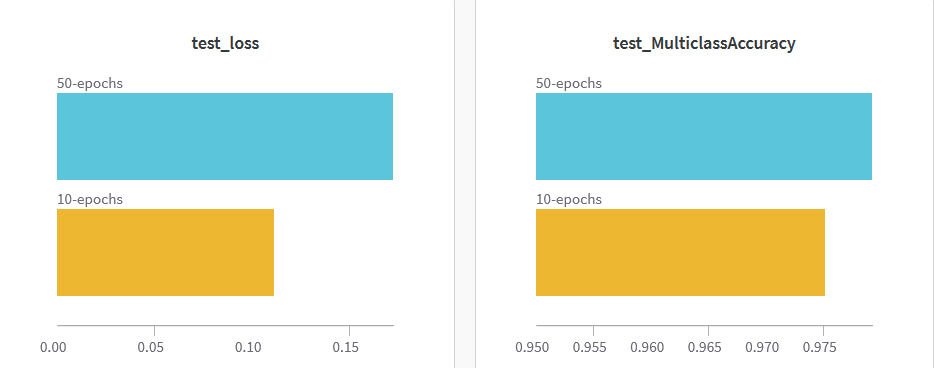

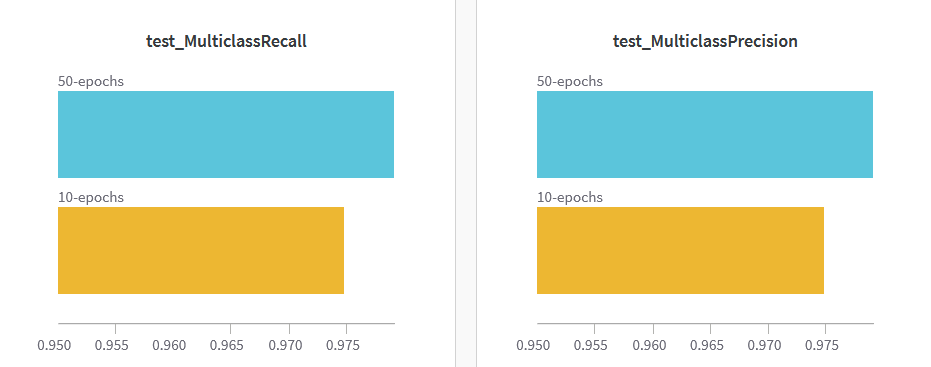

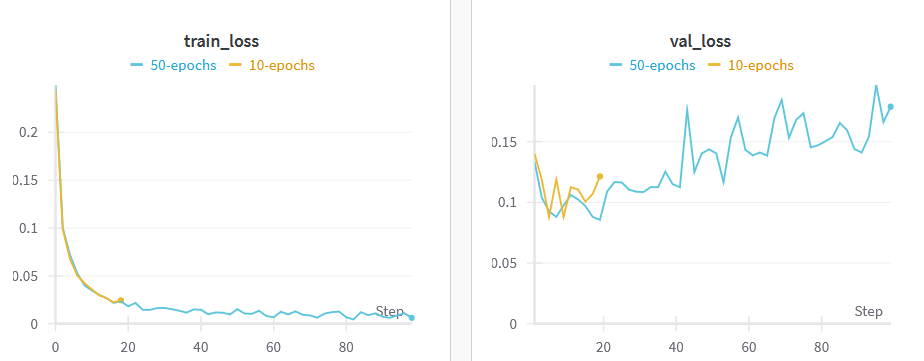

##  **Exercise 2:** Train a simple **CNN** to classify the 10 classes of CIFAR10


In [ ]:
conf_dict = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "cnn",
             "hidden_layer_sizes" : [256, 256],     #used only if model is "mlp"
             "layer_channels": [8, 16, 32, 64],                 #used only if model is "cnn" or "res_cnn"
             "loss" : "cross_entropy",
             "optimizer": "adamw",
             "lr": 1e-2,
             "dataset": "cifar10",
             "num_epochs": 30,
             "use_wandb": True,
             }

torch.autograd.set_detect_anomaly(True)
# Initialize the trainer
trainer = Trainer(conf_dict)

# Run the training and validation
trainer.run()

**Run Summary** \
Test_MulticlassAccuracy:	**0.7591** \
Test_MulticlassPrecision:	**0.77124** \
Test_MulticlassRecall:	**0.7591** \
Test_loss:	**0.7034**

## **Exercise 3**: Train a **Res-Net** to classify the 10 classes of CIFAR10

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "res_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [8, 32, 64, 128, 64],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "cifar10",
             "num_epochs": 50,
             "use_wandb": True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

**Run Summary (with skip connections)** \
Test_MulticlassAccuracy:	**0.7743** \
Test_MulticlassPrecision:	**0.7836** \
Test_MulticlassRecall:	**0.7743** \
Test_loss:	**0.70178**




##**Exercise 3.1:** Show the differences of the **Res-Net** with and without the skip connections (a normal CNN).

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "res_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [8, 32, 64, 128, 64],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": False,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "cifar10",
             "num_epochs": 20,
             "use_wandb": True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

**Run Summary (without skip connections)** \
Test_MulticlassAccuracy:	**0.7634** \
Test_MulticlassPrecision:	**0.7660** \
Test_MulticlassRecall:	**0.7496** \
Test_loss:	**0.7021**

**Results**: In this case skip connections are helping but not incredibly.

## **Exercise 3.2**: Train a Res-CNN on the 10 digits of Mnist

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "res_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "mnist",
             "num_epochs": 40,
             "use_wandb": True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv.pt")

**Results:** The training with 20 epochs shows greater performances than the MLP trained with 50, proving the supremacy of CNNs for this tasks.

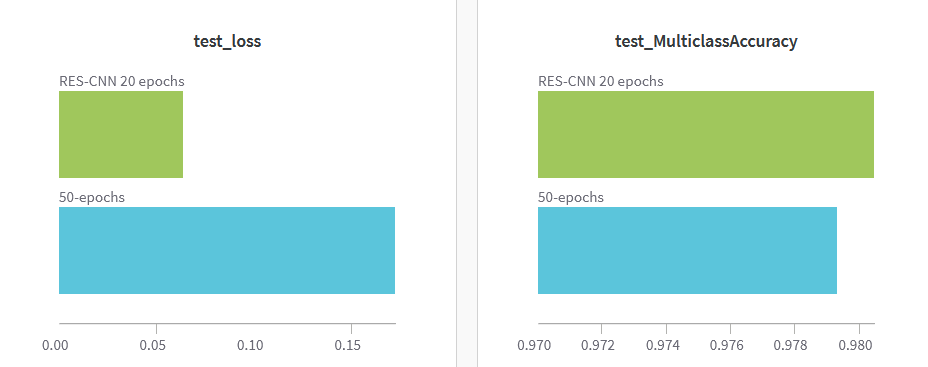

-----
## **Exercise 4**: Take one of the trained classifiers, **fully-convolutionalize** it and test it on a modified MNIST dataset.

Let's define the training and test Datasets and show some examples of the ground truth given to the model:

Training dataset example


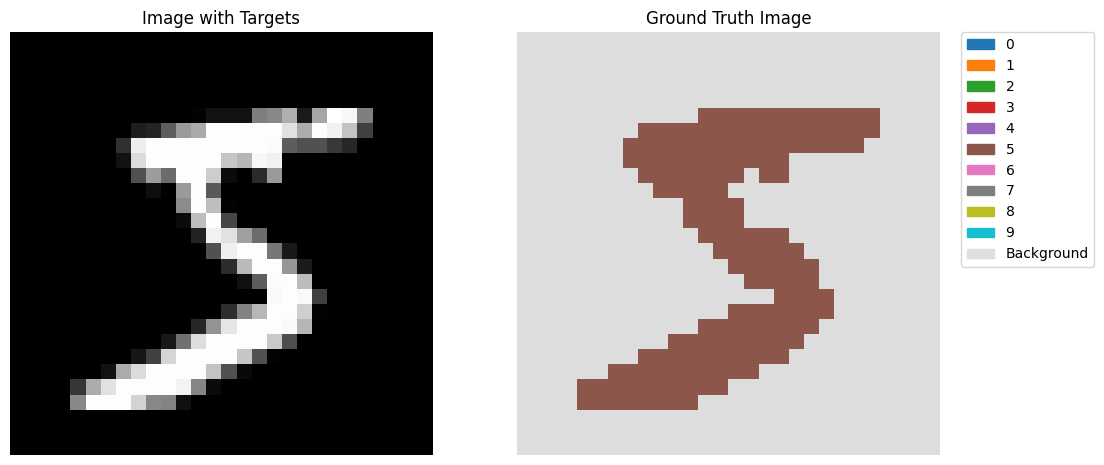

Test dataset example


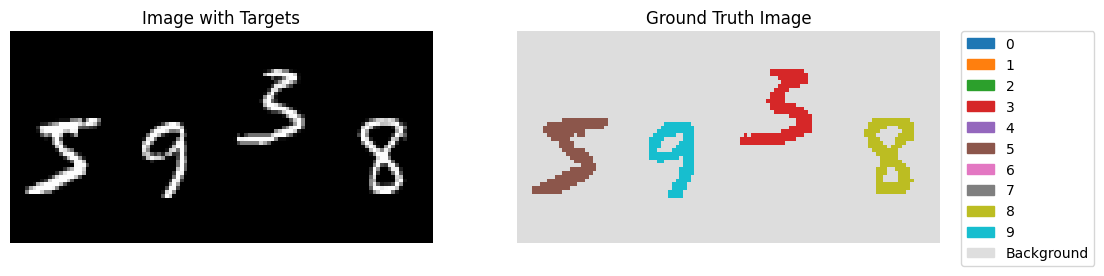

In [3]:
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

class FullyTestMNIST4(Dataset):
    def __init__(self, root, train=False, transform=None, target_transform=None, download=False, image_width=28*4, image_height=28*2):
        super().__init__()
        self.ds = MNIST(root, train=train, transform=transforms.ToTensor(), target_transform=target_transform, download=download)
        self.transform = transform
        self.image_width = image_width
        self.image_height = image_height

    def __getitem__(self, index):
        # Get four random MNIST images and their targets
        img1, target1 = self.ds[index]
        img2, target2 = self.ds[np.random.randint(0, len(self.ds))]
        img3, target3 = self.ds[np.random.randint(0, len(self.ds))]
        img4, target4 = self.ds[np.random.randint(0, len(self.ds))]

        # Create a new empty image of size (image_height, image_width)
        new_img = torch.zeros((1, self.image_height, self.image_width), dtype=img1.dtype)
        gt_img = torch.full((self.image_height, self.image_width), 10, dtype=torch.long)

        # Random shifts downwards
        y_shift1 = np.random.randint(0, 29)
        y_shift2 = np.random.randint(0, 29)
        y_shift3 = np.random.randint(0, 29)
        y_shift4 = np.random.randint(0, 29)

        # Place images in the new image with random shifts downwards
        new_img[:, y_shift1:y_shift1+28, 0:28] = img1
        gt_img[y_shift1:y_shift1+28, 0:28][img1.squeeze() > 0] = target1

        new_img[:, y_shift2:y_shift2+28, 28:56] = img2
        gt_img[y_shift2:y_shift2+28, 28:56][img2.squeeze() > 0] = target2

        new_img[:, y_shift3:y_shift3+28, 56:84] = img3
        gt_img[y_shift3:y_shift3+28, 56:84][img3.squeeze() > 0] = target3

        new_img[:, y_shift4:y_shift4+28, 84:112] = img4
        gt_img[y_shift4:y_shift4+28, 84:112][img4.squeeze() > 0] = target4

        if self.transform:
            new_img = self.transform(new_img)

        return new_img, gt_img

    def __len__(self):
        return len(self.ds)

class FullyTrainMNIST4(Dataset):
    def __init__(self, root, train=False, transform=None, target_transform=None, download=False, image_width=28*4, image_height=28*2):
        super().__init__()
        self.ds = MNIST(root, train=train, transform=transforms.ToTensor(), target_transform=target_transform, download=download)
        self.transform = transform

    def __getitem__(self, index):
        # Get four random MNIST images and their targets
        img, target1 = self.ds[index]

        gt_img = torch.full((28, 28), 10, dtype=torch.long)

        gt_img[img.squeeze() > 0] = target1

        if self.transform:
            img = self.transform(img)

        return img, gt_img  #maybe need unsqueeze on gt

    def __len__(self):
        return len(self.ds)

def show_image_with_gt(dataset, index):
    # Retrieve the image and ground truth from the dataset
    for img, gt_img in dataset:

      # Convert the image tensor to a numpy array
      img_np = img.squeeze().numpy()
      gt_img_np = gt_img.numpy()

      # Define a colormap for the numbers 0-9 using 'tab20' colormap
      base_cmap = plt.colormaps['tab20'].resampled(11)
      cmap_colors = base_cmap.colors  # Get the colors from the colormap
      cmap_colors[10] = [0.87,0.87,0.87,1]

      # Create a colormap and color dictionary
      color_dict = {i: cmap_colors[i] for i in range(11)}  # Digit 0-9 map to colors from 'tab20'

      # Convert ground truth image to colored image
      colored_gt_img = np.ones((*gt_img_np.shape, 3))  # Initialize RGB array
      for digit, color in color_dict.items():
          mask = gt_img_np == digit
          colored_gt_img[mask] = np.array(color)[:3]

      # Plot the image
      plt.figure(figsize=(12, 6))

      # Display the MNIST composite image
      plt.subplot(1, 2, 1)
      plt.imshow(img_np, cmap='gray')
      plt.title(f'Image with Targets')
      plt.axis('off')

      # Display the ground truth image with colors
      plt.subplot(1, 2, 2)
      plt.imshow(colored_gt_img)
      plt.title('Ground Truth Image')
      plt.axis('off')

      # Create legend patches
      labels = list(range(10)) + ['Background']
      patches = [mpatches.Patch(color=color_dict.get(i), label=label) for i, label in enumerate(labels)]

      # Add the legend to the plot
      plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

      plt.show()
      break

# Example usage
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

print("Training dataset example")
dataset = FullyTrainMNIST4(root='data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


# Show 1 image from the dataset along with its ground truth
show_image_with_gt(dataset, 1)

print("Test dataset example")

dataset = FullyTestMNIST4(root='data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


# Show 1 image from the dataset along with its ground truth
show_image_with_gt(dataset, 1)




#### Model Finetuning

We can finetune the model to predict the ground truth shown before with the backbone Pre-Trained on classifying the whole image.
Passing the problem of classification on a pixel-wise level makes it a very unbalanced problem since most of the pixels are background pixels. For this reason I introduced a weighting factor (in the Trainer class) to the loss as shown here:

```
if config["dataset"] == "fully_cnn_mnist":
  num_classes = 11
  major_class_weight = 0.02
  minor_class_weight = (1 - major_class_weight) / (num_classes - 1)

  class_weights = torch.tensor([minor_class_weight] * (num_classes - 1) + [major_class_weight])
  class_weights = class_weights.to(self.device)

  self.loss = nn.CrossEntropyLoss(weight=class_weights)
```

I also introduced 2 new constructor parameters to the Trainer Class:
*   **Finetune**: Used only if the model is "fully_conv_cnn". It states if the model is finetuning or just normally optimized.

*   **Checkpoint**: Checkpoint for the backbone of the "fully_conv_cnn" model.



Let's see what happens:

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "fully_conv_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "fully_cnn_mnist",
             "num_epochs": 60,
             "use_wandb": False,
             "checkpoint": "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv.pt",
             "finetune":True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_withhead.pt")



```
FullyConvCNN(
  (backbone): ResCNN(
    (blocks): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ConvBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (final_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (final_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (final_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (final_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (head): Identity()
  )
  (classification_head): Sequential(
    (0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 11, kernel_size=(1, 1), stride=(1, 1))
  )
)```



**Run Summary**:\
Test Loss: **0.1778**\
Test_MulticlassAccuracy: **0.9463** \
Test_MulticlassPrecision: **0.6291**\
Test_MulticlassRecall: **0.7002**

**Results:** By looking at the performances and analyzing the outputs the model is actually learning something but it looks like the last layer's receptive field is not enough to understand the full digit.

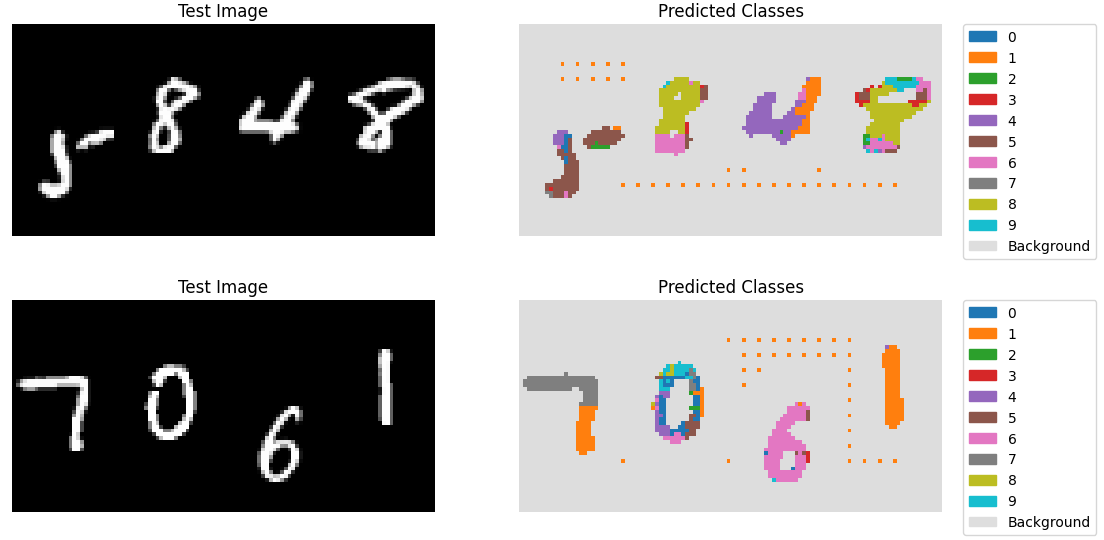

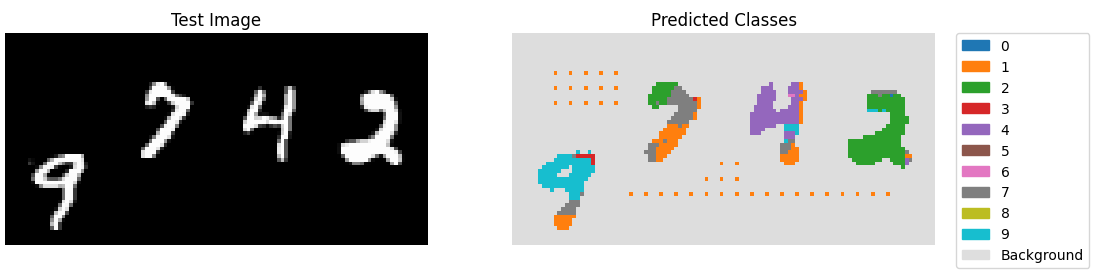

For example by looking at the first prediction for this image the 9 is predicted in a good way for the characteristic part of the 9 which is the top part but in the bottom part it is misinterpreted as a 1 or a 7, which is pretty understandable if the model is looking just at the bottom part without considering the top part.

#### Redefine Res-CNN models

So let's try to enlarge the receptive field of the Fully convolutional CNN, in particular of the backbone by raising the kernel size from 3 to 7:

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, num, input_channels, output_channels, kernel_size=7, res_connection=False):
        super(ConvBlock, self).__init__()
        self.res_connection = res_connection

        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=(kernel_size // 2))
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=(kernel_size // 2))
        self.bn2 = nn.BatchNorm2d(input_channels)

        self.final_conv = nn.Conv2d(input_channels, output_channels, 1)
        self.final_bn = nn.BatchNorm2d(output_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.res_connection:
            out += identity

        out = self.final_bn(self.final_conv(out))

        return out


class ResCNN(nn.Module):
    def __init__(self, layer_channels, num_repeats, output_dim=10, res_connection=False):
        super(ResCNN, self).__init__()
        self.res_connection = res_connection

        blocks = []

        blocks.append(nn.Conv2d(layer_channels[0], layer_channels[1], kernel_size=6, stride = 4, padding=1))

        for i in range(1, len(layer_channels) - 1):
            in_channels = layer_channels[i]
            out_channels = layer_channels[i + 1]
            block = ConvBlock(num_repeats, in_channels, out_channels, res_connection=self.res_connection)
            blocks.append(block)

        self.blocks = nn.ModuleList(blocks)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(layer_channels[-1], 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.head(x)
        return x


layer_channels = [3, 16, 32, 64, 128, 256]
model = ResCNN(layer_channels=layer_channels, num_repeats=2, output_dim=10, res_connection=True)

x = torch.rand(3, 3, 28, 28)
out = model(x)
print(out.shape)

class FullyConvCNN(nn.Module):
    def __init__(self, layer_channels, num_repeats, output_dim=10, res_connection=False, checkpoint=None):
        super(FullyConvCNN, self).__init__()
        self.backbone = ResCNN(layer_channels, num_repeats, output_dim, res_connection)
        if checkpoint != None:
            self.backbone.load_state_dict(torch.load(checkpoint))
        self.backbone.head = nn.Identity()


        self.classification_head = nn.Sequential(
          #nn.MaxPool2d(kernel_size=4, stride=4),
          nn.ConvTranspose2d(layer_channels[-1], layer_channels[-1]//2, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
          nn.BatchNorm2d(layer_channels[-1]//2),
          nn.ConvTranspose2d(layer_channels[-1]//2, layer_channels[-1]//4, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
          nn.BatchNorm2d(layer_channels[-1]//4),
          nn.Conv2d(layer_channels[-1]//4, output_dim+1, kernel_size=1),
        )

    def forward(self, x):
        return self.classification_head(self.backbone(x))


layer_channels = [3, 64, 128, 256, 256, 256]
model = FullyConvCNN(layer_channels=layer_channels, num_repeats=2, output_dim=10, res_connection=True)
x = torch.rand(3, 3, 28, 28)
out = model(x)
print(out.shape)

torch.Size([3, 10])
torch.Size([3, 11, 28, 28])


#### Backbone Pre-Training

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "res_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128, 256],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "mnist",
             "num_epochs": 20,
             "use_wandb": True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_larger.pt")



```
ResCNN(
  (blocks): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): ConvBlock(
      (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (final_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (final_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (final_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (final_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (conv1): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (final_conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (final_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (head): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=10, bias=True)
  )
)```



**Run summary:**

test_MulticlassAccuracy:	**0.9892** \
test_MulticlassPrecision:	**0.98921** \
test_MulticlassRecall:	**0.98907** \
test_loss:	**0.03395**

#### Retrain the head

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "fully_conv_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128, 256],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "fully_cnn_mnist",
             "num_epochs": 60,
             "use_wandb": False,
             "checkpoint": "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_larger.pt",
             "finetune":True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_withhead2.pt")



```
ResCNN(
  (blocks): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(6, 6), stride=(4, 4), padding=(1, 1))
    (1): ConvBlock(
      (conv1): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (final_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (final_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (final_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (final_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): ConvBlock(
      (conv1): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (final_conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (final_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    )
    (head): Identity()
  )
  (classification_head): Sequential(
    (0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 11, kernel_size=(1, 1), stride=(1, 1))
  )


  ```



**Run Summary**:\
Test Loss: **7.6767**\
Test_MulticlassAccuracy: **0.9037**\
Test_MulticlassPrecision: **0.4633**\
Test_MulticlassRecall: **0.0922**

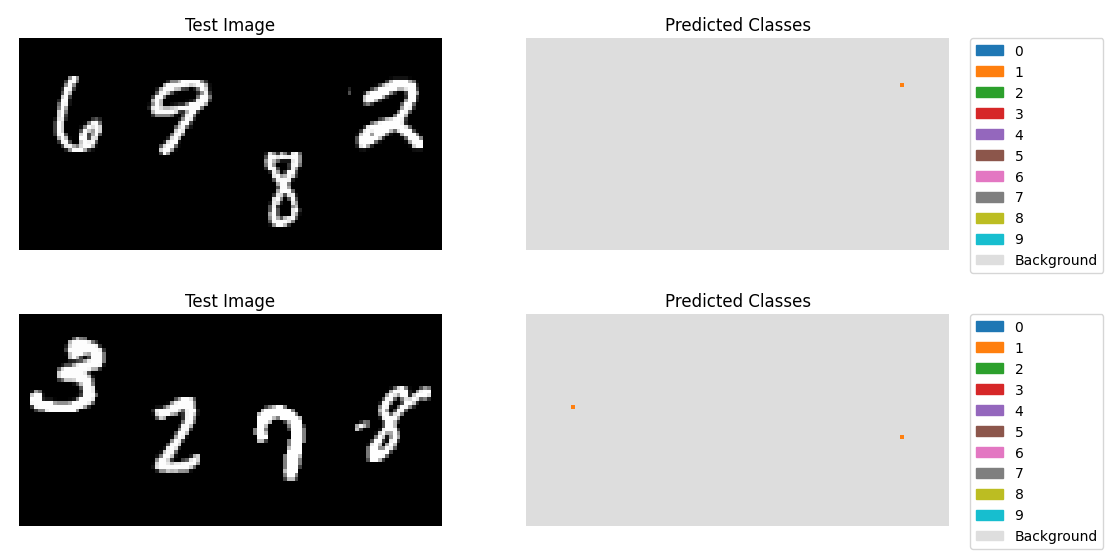

**OOOOPS:** Something went really wrong, the model found convenient to just predict always background since it is the most common class. This means the unbalanced problem was not fully rebalanced. Let's decrease the weight of the background class by a factor of 10 and run again:

#### Let's change the loss weights since it is considering just the background

In [84]:
class Trainer:
    def __init__(self, config):


        self.config = config
        if config["use_wandb"] == True:
          self.use_wandb = True
          wandb.init(project="LAB1", config=config)

        else:
          self.use_wandb = False

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epochs = config["num_epochs"]

        match config["loss"]:

          case "cross_entropy":
            self.loss = nn.CrossEntropyLoss()
            if config["dataset"] == "fully_cnn_mnist":
              num_classes = 11
              major_class_weight = 0.0005
              minor_class_weight = (1 - major_class_weight) / (num_classes - 1)

              class_weights = torch.tensor([minor_class_weight] * (num_classes - 1) + [major_class_weight])
              class_weights = class_weights.to(self.device)
              print("To solve class unbalance these are the weights given to the loss:")
              print(class_weights)
              # Define the criterion with the class weights
              self.loss = nn.CrossEntropyLoss(weight=class_weights)

          case _:
            raise ValueError(f'Loss not found. Received {config["loss"]}.')


        match config["dataset"]:

          case "mnist":
            dataset = MNIST
            self.input_size = 28*28
            self.output_size = 10
            self.input_channels = 1
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
            test_dataset = dataset(root='./data', train=False, download=True, transform=transform)
            train_dataset, validation_dataset = split_validation_train(train_dataset=train_dataset, val_size=0.2)

            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

          case "cifar10":
            dataset = CIFAR10
            self.input_size = 32*32*3
            self.output_size = 10
            self.input_channels = 3
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            train_dataset = dataset(root='./data', train=True, download=True, transform=transform)
            test_dataset = dataset(root='data', train=False, transform=transform, download=True)
            train_dataset, validation_dataset = split_validation_train(train_dataset=train_dataset, val_size=0.2)

            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

          case "fully_cnn_mnist":
            dataset = MNIST
            self.input_size = 28*28
            self.output_size = 10
            self.input_channels = 1
            transform_train = transforms.Compose([
                transforms.ToPILImage(),
                #transforms.RandomAffine(0, translate=(0.4, 0.4)),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            transform_test = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
            train_dataset = FullyTrainMNIST4(root='data', train=True, transform=transform_train, download=True)
            test_dataset = FullyTestMNIST4(root='data', train=False, transform=transform_test, download=True)
            train_dataset, validation_dataset = split_validation_train(train_dataset=train_dataset, val_size=0.2)

            self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            self.val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)
            self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

          case _:
            raise ValueError(f'Dataset not found. Received {config["dataset"]}.')





        self.metrics = []
        output_size = self.output_size
        if config["model"] == "fully_conv_cnn": # it has the background also
          output_size += 1

        for metric in config["metrics"]:

            match metric:

                case "accuracy":
                    self.metrics.append(torchmetrics.Accuracy(task="multiclass", num_classes=output_size).to(self.device))

                case "precision":
                    self.metrics.append(torchmetrics.Precision(task="multiclass", average='macro', num_classes=output_size).to(self.device))

                case "recall":
                    self.metrics.append(torchmetrics.Recall(task="multiclass", average='macro', num_classes=output_size).to(self.device))

                case _:
                    raise ValueError(f'Metric not found. Received {metric}.')


        match config["model"]:

            case "mlp":
                layer_sizes = [self.input_size] + config["hidden_layer_sizes"] + [self.output_size]
                self.model = MLP(layer_sizes)

            case "cnn":
                layer_channels = [self.input_channels] + config["layer_channels"]
                self.model = CNN(layer_channels=layer_channels, output_dim=self.output_size)

            case "res_cnn":
                layer_channels = [self.input_channels] + config["layer_channels"]
                self.model = ResCNN(layer_channels=layer_channels, num_repeats=config["block_layers"], output_dim=self.output_size, res_connection=config["res"])

            case "fully_conv_cnn":
                layer_channels = [self.input_channels] + config["layer_channels"]
                self.model = FullyConvCNN(layer_channels=layer_channels, num_repeats=config["block_layers"], output_dim=self.output_size, res_connection=config["res"], checkpoint=config["checkpoint"])

            case _:
                raise ValueError(f'Model not found. Received {config["model"]}.')

        self.model.to(self.device)

        self.finetune = config.get("finetune", False)
        print("Finetune:")
        print(self.finetune)
        if self.finetune and config["model"] == "fully_conv_cnn":
            backbone_params = list(self.model.backbone.parameters())
            head_params = list(self.model.classification_head.parameters())
            lrs = [
                  {'params': backbone_params, 'lr': config["lr"]/1e2},
                  {'params': head_params, 'lr': config["lr"]}
            ]
        else:
            lrs = [
                  {'params': self.model.parameters(), 'lr': config["lr"]}
            ]

        match config["optimizer"]:

            case "adam":
                self.optimizer = optim.Adam(lrs)

            case "sgd":
                self.optimizer = optim.SGD(lrs)

            case "adamw":
                self.optimizer = optim.AdamW(lrs)

            case _:
                raise ValueError(f'Optimizer not found. Received {config["optimizer"]}.')



    def train_one_epoch(self, epoch):
        self.model.train()
        running_loss = 0.0

        for inputs, labels in self.train_loader:
            self.optimizer.zero_grad()
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs).to(self.device)
            loss = self.loss(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Update metrics
            for metric in self.metrics:
                metric.update(outputs, labels)

        epoch_loss = running_loss / len(self.train_loader.dataset)

        # Log training loss and metrics to wandb
        metrics_log = {f"train_{metric.__class__.__name__}": metric.compute().item() for metric in self.metrics}
        if self.use_wandb:
          wandb.log({"train_loss": epoch_loss, **metrics_log})

        print(f'Epoch {epoch+1}/{self.num_epochs}, Loss: {epoch_loss:.4f}, ' +
              ", ".join([f"{k}: {v:.4f}" for k, v in metrics_log.items()]))

        # Reset metrics
        for metric in self.metrics:
            metric.reset()

    def validate(self, epoch):
        self.model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.loss(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Update metrics
                for metric in self.metrics:
                    metric.update(outputs, labels)

        epoch_val_loss = val_loss / len(self.val_loader.dataset)
        metrics_log = {f"val_{metric.__class__.__name__}": metric.compute().item() for metric in self.metrics}
        if self.use_wandb:
          wandb.log({"val_loss": epoch_val_loss, **metrics_log})

        print(f'Validation Loss: {epoch_val_loss:.4f}, ' +
              ", ".join([f"{k}: {v:.4f}" for k, v in metrics_log.items()]))

        # Reset metrics
        for metric in self.metrics:
            metric.reset()

    def test(self):
          self.model.eval()
          test_loss = 0.0
          with torch.no_grad():
              for inputs, labels in self.test_loader:
                  inputs, labels = inputs.to(self.device), labels.to(self.device)
                  outputs = self.model(inputs)
                  loss = F.cross_entropy(outputs, labels)
                  test_loss += loss.item() * inputs.size(0)

                  # Update metrics
                  for metric in self.metrics:
                      metric.update(outputs, labels)

          test_loss /= len(self.test_loader.dataset)
          metrics_log = {f"test_{metric.__class__.__name__}": metric.compute().item() for metric in self.metrics}
          if self.use_wandb:
            wandb.log({"test_loss": test_loss, **metrics_log})

          print(f'Test Loss: {test_loss:.4f}, ' +
                ", ".join([f"{k}: {v:.4f}" for k, v in metrics_log.items()]))

          # Reset metrics
          for metric in self.metrics:
              metric.reset()

          if self.config["dataset"] == "fully_cnn_mnist":
              self.show_image_with_gt(1)

    def run(self):
        print(self.model)
        for epoch in range(self.num_epochs):
            self.train_one_epoch(epoch)
            self.validate(epoch)
            if epoch%10 == 0:
              self.test()

        if self.test_loader is not None:
            self.test()
        if self.use_wandb:
          wandb.finish()



    def show_image_with_gt(self, index):
        # Retrieve the image and ground truth from the dataset
        i = 0
        for img, _ in self.test_loader:
            img = img.to(self.device)
            output = self.model(img)
            img = img.cpu()
            output = output.cpu()
            img_np = img.squeeze().numpy()
            output = output.detach().numpy()

            for i in range(2):  # img_np.shape[0]
                # Convert the image tensor to a numpy array
                img = img_np[i]
                gt_img_np = output[i]

                # Get predicted classes
                predicted_classes = gt_img_np.argmax(axis=0)

                # Calculate confidence as the difference between max and second max logits
                sorted_logits = np.sort(gt_img_np, axis=0)
                max_logits = sorted_logits[-1]
                second_max_logits = sorted_logits[-2]
                confidence = max_logits - second_max_logits

                base_cmap = plt.colormaps['tab20'].resampled(11)
                cmap_colors = base_cmap.colors  # Get the colors from the colormap
                cmap_colors[10] = [0.87, 0.87, 0.87, 1]

                color_dict = {i: cmap_colors[i] for i in range(11)}  # Digit 0-9 map to colors from 'tab20'

                colored_gt_img = np.ones((*predicted_classes.shape, 3))  # Initialize RGB array
                for digit, color in color_dict.items():
                    mask = predicted_classes == digit
                    colored_gt_img[mask] = np.array(color)[:3]

                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(img, cmap='gray')
                plt.title('Test Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(colored_gt_img)
                plt.title('Predicted Classes')
                plt.axis('off')

                # Create legend patches
                labels = list(range(10)) + ['Background']
                patches = [mpatches.Patch(color=color_dict.get(i), label=label) for i, label in enumerate(labels)]

                # Add the legend to the plot
                plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

                plt.subplot(1, 3, 3)
                heatmap = plt.imshow(confidence, cmap='hot', interpolation='nearest')
                plt.colorbar(heatmap, fraction=0.03, pad=0.04)
                plt.title('Confidence Heatmap')
                plt.axis('off')

                plt.tight_layout(pad=3.0)  # Adjust layout to prevent overlap

                plt.show()

            if i >= index:
                break
            i += 1



def split_validation_train(train_dataset, val_size):
    val_size = int(len(train_dataset) * val_size)

    I = np.random.permutation(len(train_dataset))
    validation_dataset = Subset(train_dataset, I[:val_size])
    train_dataset = Subset(train_dataset, I[val_size:])

    return train_dataset, validation_dataset

#### Let's try again

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "fully_conv_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128, 256],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "fully_cnn_mnist",
             "num_epochs": 60,
             "use_wandb": False,
             "checkpoint": "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_larger.pt",
             "finetune":True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_withhead2.pt")

This is still not working

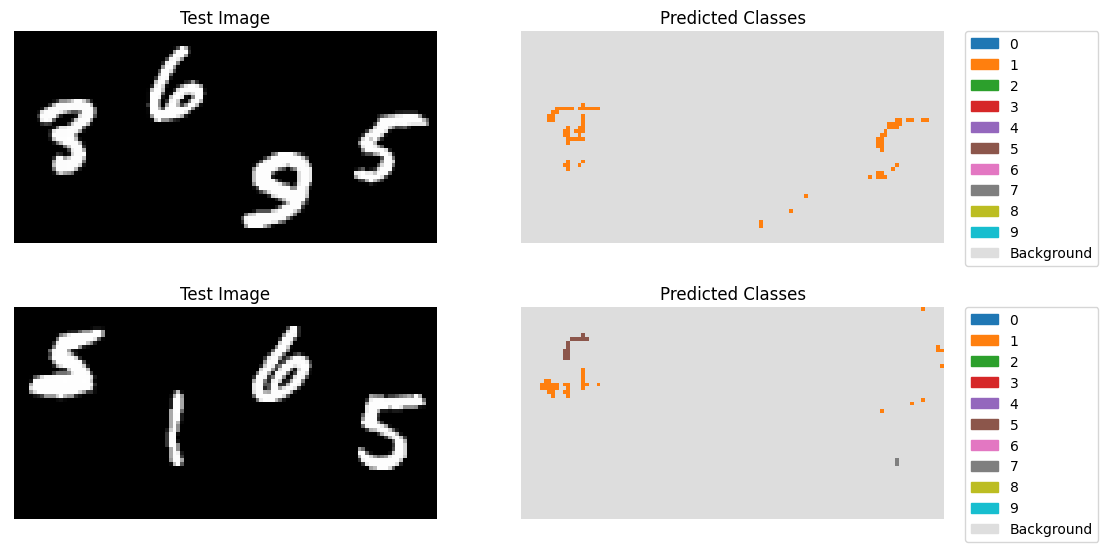

Since it is not working probably the receptive fields of the last layer's neurons are too wide now so let's reduce the kernel size to 5.

In [45]:
class ConvBlock(nn.Module):
    def __init__(self, num, input_channels, output_channels, kernel_size=5, res_connection=False):
        super(ConvBlock, self).__init__()
        self.res_connection = res_connection

        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=(kernel_size // 2))
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size, padding=(kernel_size // 2))
        self.bn2 = nn.BatchNorm2d(input_channels)

        self.final_conv = nn.Conv2d(input_channels, output_channels, 1)
        self.final_bn = nn.BatchNorm2d(output_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.res_connection:
            out += identity

        out = self.final_bn(self.final_conv(out))

        return out


class ResCNN(nn.Module):
    def __init__(self, layer_channels, num_repeats, output_dim=10, res_connection=False):
        super(ResCNN, self).__init__()
        self.res_connection = res_connection

        blocks = []

        blocks.append(nn.Conv2d(layer_channels[0], layer_channels[1], kernel_size=3, stride = 1, padding=1))

        for i in range(1, len(layer_channels) - 1):
            in_channels = layer_channels[i]
            out_channels = layer_channels[i + 1]
            block = ConvBlock(num_repeats, in_channels, out_channels, res_connection=self.res_connection)
            blocks.append(block)

        self.blocks = nn.ModuleList(blocks)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(layer_channels[-1], 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.head(x)
        return x


layer_channels = [3, 16, 32, 64, 128, 256]
model = ResCNN(layer_channels=layer_channels, num_repeats=2, output_dim=10, res_connection=True)

x = torch.rand(3, 3, 28, 28)
out = model(x)
print(out.shape)

class FullyConvCNN(nn.Module):
    def __init__(self, layer_channels, num_repeats, output_dim=10, res_connection=False, checkpoint=None):
        super(FullyConvCNN, self).__init__()
        self.backbone = ResCNN(layer_channels, num_repeats, output_dim, res_connection)
        if checkpoint != None:
            self.backbone.load_state_dict(torch.load(checkpoint))
        self.backbone.head = nn.Identity()


        self.classification_head = nn.Sequential(
          nn.MaxPool2d(kernel_size=4, stride=4),
          nn.ConvTranspose2d(layer_channels[-1], layer_channels[-1]//2, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
          nn.BatchNorm2d(layer_channels[-1]//2),
          nn.ConvTranspose2d(layer_channels[-1]//2, layer_channels[-1]//4, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1),
          nn.BatchNorm2d(layer_channels[-1]//4),
          nn.Conv2d(layer_channels[-1]//4, output_dim+1, kernel_size=1),
        )

    def forward(self, x):
        return self.classification_head(self.backbone(x))


layer_channels = [3, 64, 128, 256, 256, 256]
model = FullyConvCNN(layer_channels=layer_channels, num_repeats=2, output_dim=10, res_connection=True)
x = torch.rand(3, 3, 28, 28)
out = model(x)
print(out.shape)

torch.Size([3, 10])
torch.Size([3, 11, 28, 28])


Let's also add a traslation in the training dataset as well because I think it might help the model to be translation invariant:

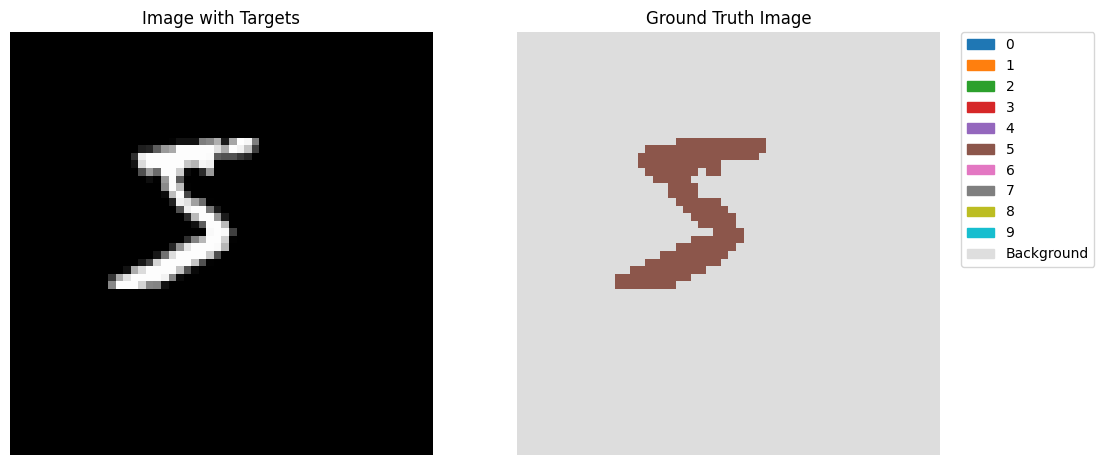

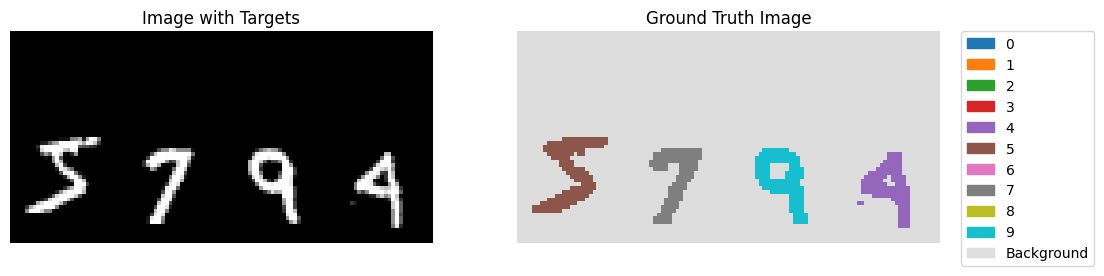

In [63]:
class FullyTrainMNIST4(Dataset):
    def __init__(self, root, train=False, transform=None, target_transform=None, download=False, image_width=28*2, image_height=28*2):
        super().__init__()
        self.ds = MNIST(root, train=train, transform=transforms.ToTensor(), target_transform=target_transform, download=download)
        self.transform = transform
        self.image_width = image_width
        self.image_height = image_height

    def __getitem__(self, index):
        # Get four random MNIST images and their targets
        img, target1 = self.ds[index]

        new_img = torch.zeros((1, self.image_height, self.image_width), dtype=img.dtype)
        gt_img = torch.full((self.image_height, self.image_width), 10, dtype=torch.long)

        # Random shifts downwards
        y_shift = np.random.randint(0, 29)
        x_shift = np.random.randint(0, 29)

        # Place images in the new image with random shifts downwards
        new_img[:, y_shift:y_shift+28, x_shift:x_shift+28] = img
        gt_img[y_shift:y_shift+28,x_shift:x_shift+28][img.squeeze() > 0] = target1


        if self.transform:
            new_img = self.transform(new_img)

        return new_img, gt_img

        # Create a new empty image of size (image_height, image_width)
        y_shift = np.random.randint(0, 29)
        x_shift = np.random.randint(0, 29)
        new_img = torch.zeros((1, self.image_height, self.image_width), dtype=img.dtype)
        gt_img = torch.full((self.image_height, self.image_width), 10, dtype=torch.long)

        gt_img = torch.full((28, 28), 10, dtype=torch.long)

        gt_img[img.squeeze() > 0] = target1

        if self.transform:
            img = self.transform(img)

        return img, gt_img  #maybe need unsqueeze on gt

    def __len__(self):
        return len(self.ds)

def show_image_with_gt(dataset, index):
    # Retrieve the image and ground truth from the dataset
    for img, gt_img in dataset:

      # Convert the image tensor to a numpy array
      img_np = img.squeeze().numpy()
      gt_img_np = gt_img.numpy()

      # Define a colormap for the numbers 0-9 using 'tab20' colormap
      base_cmap = plt.colormaps['tab20'].resampled(11)
      cmap_colors = base_cmap.colors  # Get the colors from the colormap
      cmap_colors[10] = [0.87,0.87,0.87,1]

      # Create a colormap and color dictionary
      color_dict = {i: cmap_colors[i] for i in range(11)}  # Digit 0-9 map to colors from 'tab20'

      # Convert ground truth image to colored image
      colored_gt_img = np.ones((*gt_img_np.shape, 3))  # Initialize RGB array
      for digit, color in color_dict.items():
          mask = gt_img_np == digit
          colored_gt_img[mask] = np.array(color)[:3]

      # Plot the image
      plt.figure(figsize=(12, 6))

      # Display the MNIST composite image
      plt.subplot(1, 2, 1)
      plt.imshow(img_np, cmap='gray')
      plt.title(f'Image with Targets')
      plt.axis('off')

      # Display the ground truth image with colors
      plt.subplot(1, 2, 2)
      plt.imshow(colored_gt_img)
      plt.title('Ground Truth Image')
      plt.axis('off')

      # Create legend patches
      labels = list(range(10)) + ['Background']
      patches = [mpatches.Patch(color=color_dict.get(i), label=label) for i, label in enumerate(labels)]

      # Add the legend to the plot
      plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

      plt.show()
      break

# Example usage
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

dataset = FullyTrainMNIST4(root='data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


# Show 1 image from the dataset along with its ground truth
show_image_with_gt(dataset, 1)

dataset = FullyTestMNIST4(root='data', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)


# Show 1 image from the dataset along with its ground truth
show_image_with_gt(dataset, 1)

Let's pre-train the resnet with kernel size = 5:

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "res_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "mnist",
             "num_epochs": 30,
             "use_wandb": True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_medium.pt")

And now let's train the fully_conv_cnn model:

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "fully_conv_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "sgd",
             "lr": 0.01,
             "dataset": "fully_cnn_mnist",
             "num_epochs": 60,
             "use_wandb": False,
             "checkpoint": "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_medium.pt",
             "finetune":True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

torch.save(trainer_res.model.state_dict(), "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_withhead3.pt")



```
FullyConvCNN(
  (backbone): ResCNN(
    (blocks): ModuleList(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ConvBlock(
        (conv1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (final_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (final_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): ConvBlock(
        (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (final_conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (final_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (head): Identity()
  )
  (classification_head): Sequential(
    (0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 11, kernel_size=(1, 1), stride=(1, 1))
  )
)
```



**Run Summary**:

Test Loss: **0.3200** \
Test_MulticlassAccuracy: **0.9319**\
Test_MulticlassPrecision: **0.6036**\
Test_MulticlassRecall: **0.9136**

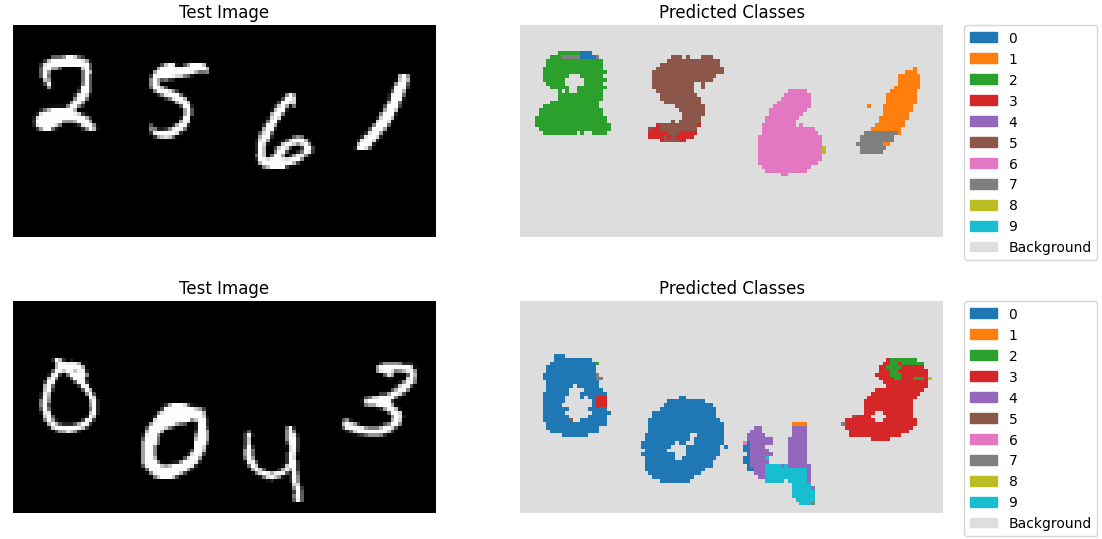

## Final (and most successful) run

The last try I was going to make to make it better was to change the optimizer to **Adamw** and this was actually a great idea since the model increased its performances a lot. \
I also add a **confidence** (highest logit - second highest logit) heatmap to the test predictions to see how confident the model was in the spot where it is wrong.

In [ ]:
conf_dict_res = {"metrics" : ["accuracy", "precision", "recall"],
             "model" : "fully_conv_cnn",
             "hidden_layer_sizes" : [256, 256, 256],     #used only if model is "mlp"
             "layer_channels": [32, 64, 128],                 #used only if model is "cnn" or "res_cnn"
             "block_layers": 2,                     #used only if model is "res_cnn"
             "res": True,
             "loss" : "cross_entropy",
             "optimizer": "adamw",
             "lr": 0.01,
             "dataset": "fully_cnn_mnist",
             "num_epochs": 60,
             "use_wandb": True,
             "checkpoint": "/content/drive/MyDrive/LaboratoryDLA/LAB1/mnist_fully_conv_medium.pt",
             "finetune":True,
             }

# Initialize the trainer
trainer_res = Trainer(conf_dict_res)

# Run the training and validation
trainer_res.run()

**Run summary:**

test_MulticlassAccuracy	**0.95327**\
test_MulticlassPrecision	**0.69726**\
test_MulticlassRecall	**0.95055**\
test_loss	**0.24853**

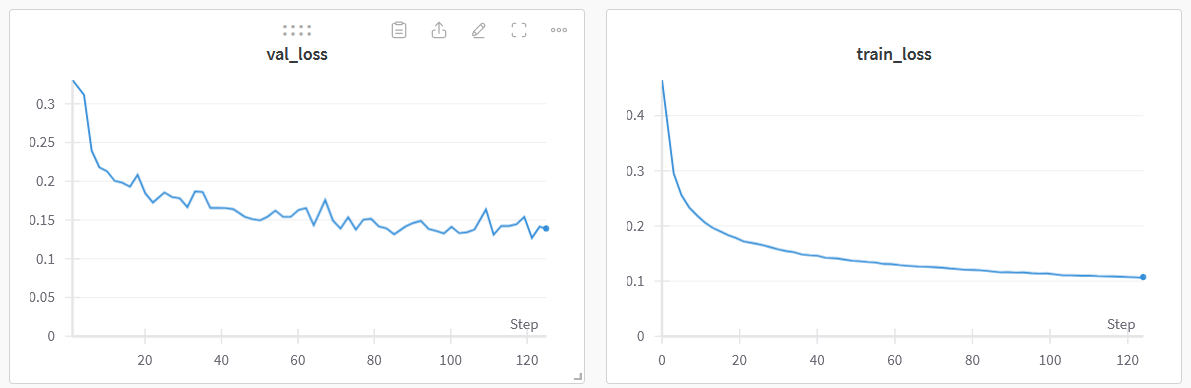

The model now is working in a really good way and making the right prediction almost for every pixel. \
By looking at the **confidence heatmap** we can find out very interesting things about the wrong predictions:

*   The confusing digits of MNIST are all characterized by low confidence in the heatmap.
*   In the rare pixels where the model make the wrong prediction the confidence is pretty low.






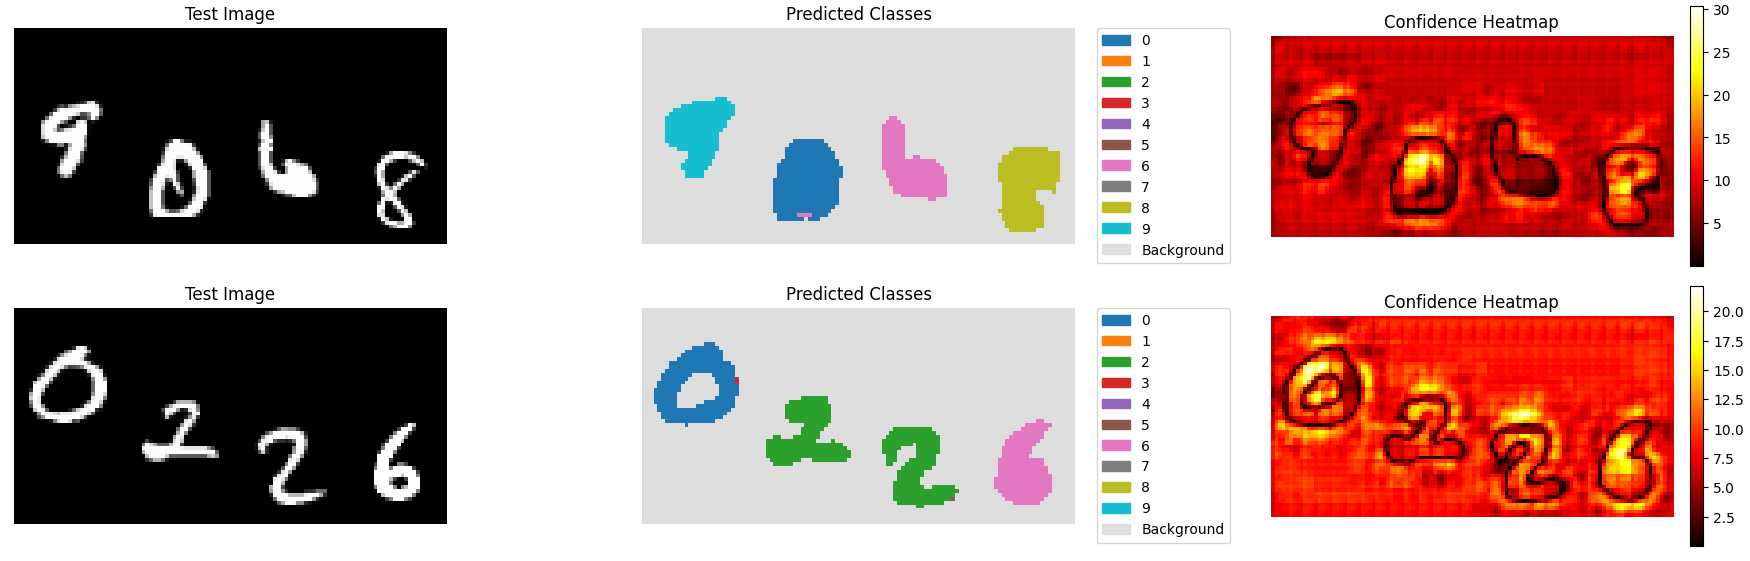

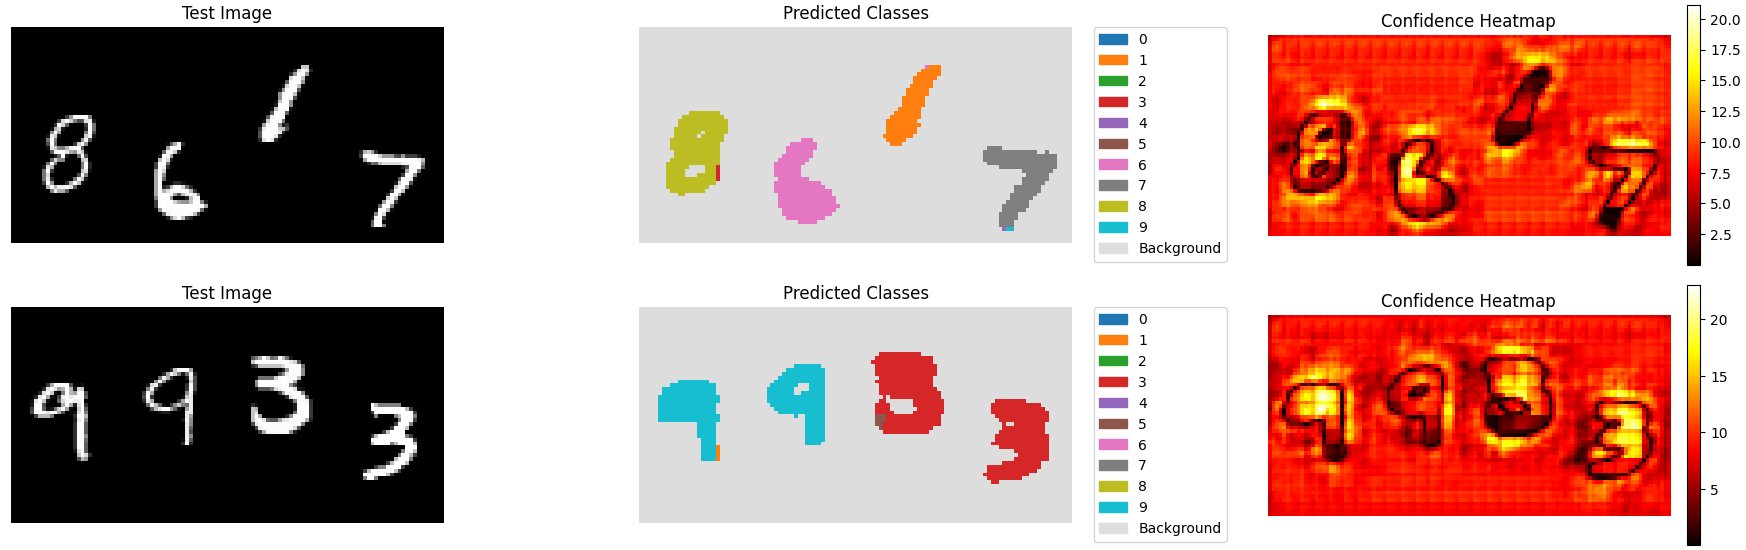

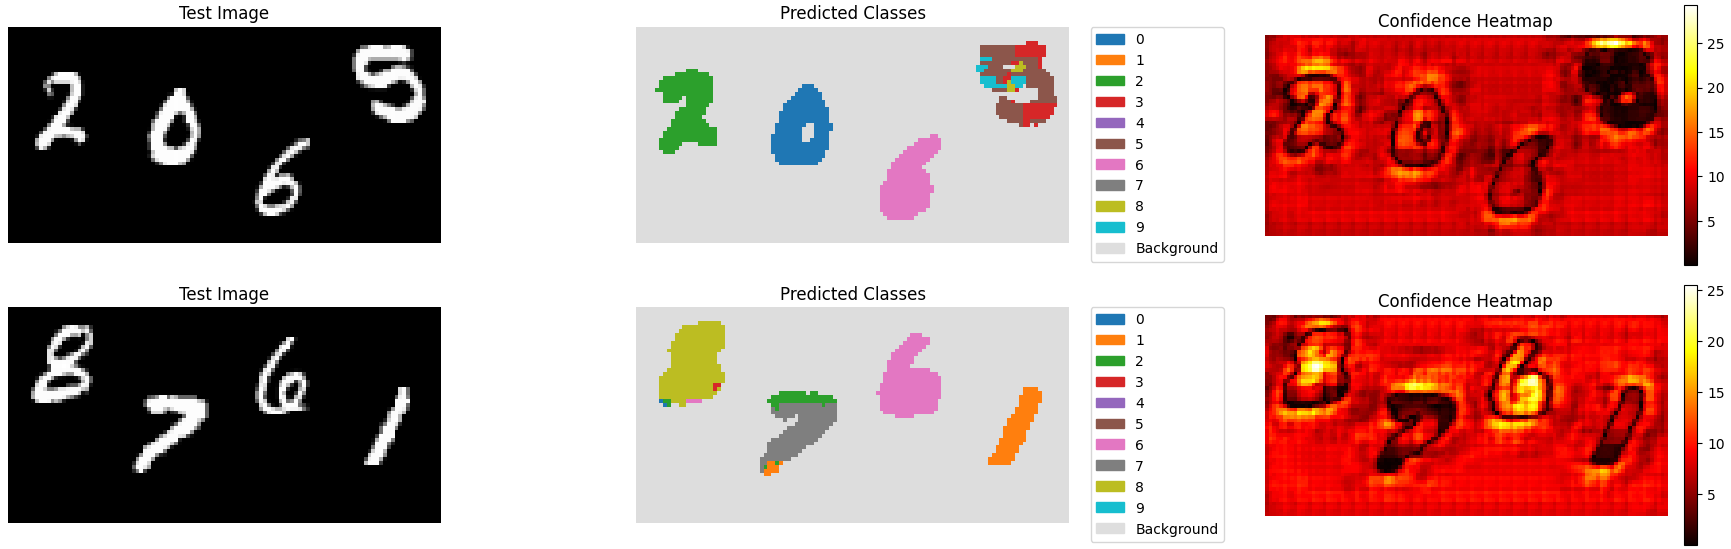

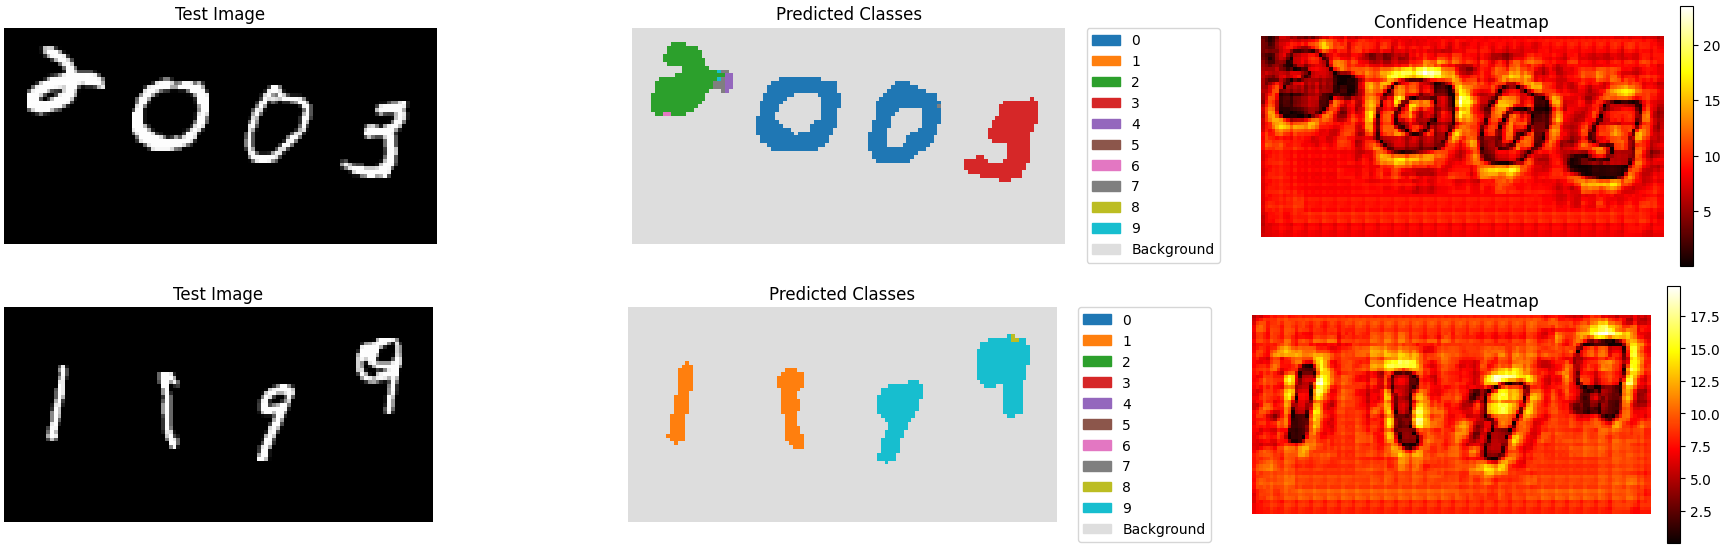

I also found very interesting that already at the early stages of the training (epoch 1) the output were very promising:

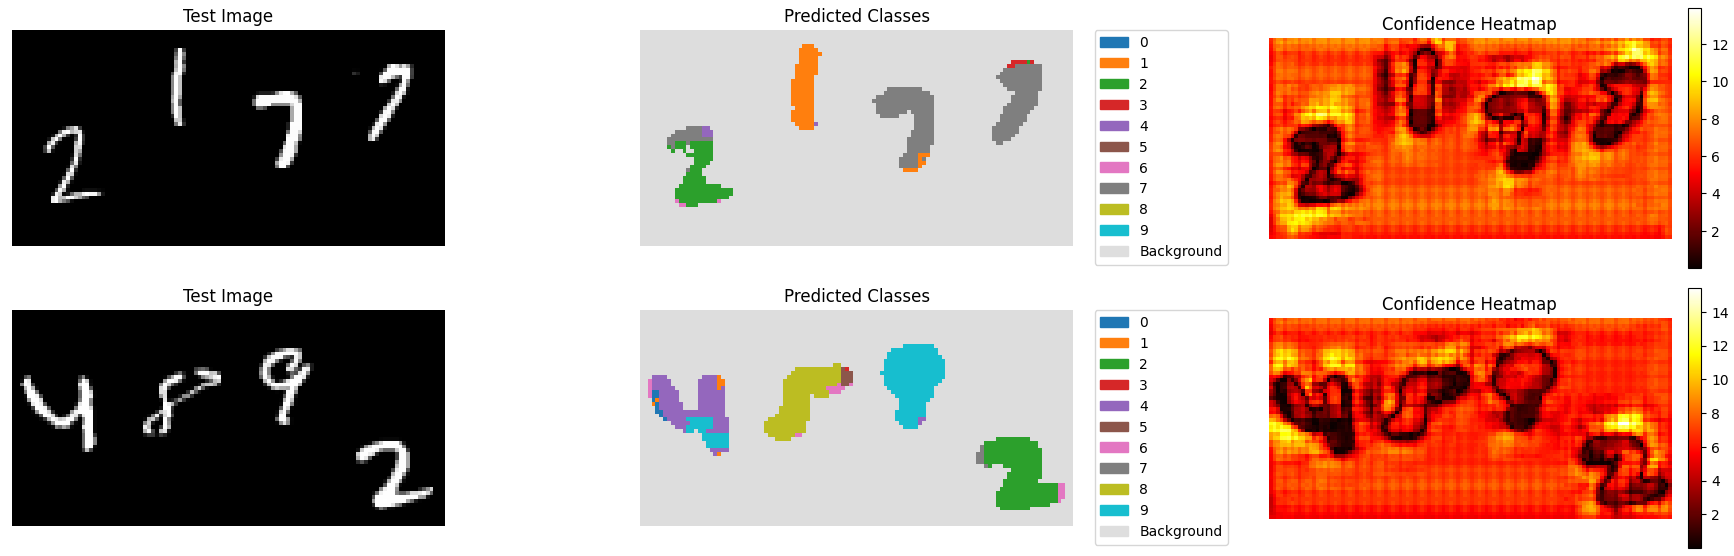

However the confidence after the first epoch was lower compared to the final predictions, so the subsequent training just made the general prediction better and increased the confidence.